In [119]:
#@formatter:off
%load_ext autoreload
%autoreload 2
#@formatter:on

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Malaria Modelling - benchmarking script 

## Programming
### Python Package Importation

This script use:
- `pandas` - data importation, manipulation.
- `seaborn` and `matplotlib` - plotting
- `numpy` - matrix calculation
- `jupyter notebook` - editing
- `black` - formatting
- `pyshp` - gis shape file
- `lxml` - xml exporting

In [120]:

from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shapefile

from mbench import demographic, util
from mbench.intervention import efficacy
from mbench.util.xml_import import load_xml_config

sns.set_theme(style="whitegrid", palette="pastel")

data_dir = "../../Data/"
openmalaria_xml_config_path = "/Users/sepmein/Dropbox/benchmarking/Data/openmalaria/12936_2017_2051_MOESM1_ESM.xml"

### Create pandas dataframe for holding all data
- load gha dataframe index from PHC summary
- create columns using parameters list from Imperial model

In [121]:
# index
gha_demographic_adm1_2020_phc = pd.read_excel(
    data_dir + "GHA/Demographic/2021_PHC/2021 PHC summary.xlsx"
)
gha_demographic_adm1_2020_mean = gha_demographic_adm1_2020_phc[["region", "mean_age"]]
gha_demographic_adm1_2020_mean = demographic.adm1_name(
    df=gha_demographic_adm1_2020_mean, original_column_name="region"
)

In [122]:
columns = [
    "eta",
    "rho",
    "a0",
    "sigma2",
    "max_age",
    "rA",
    "rT",
    "rD",
    "rU",
    "rP",
    "dE",
    "delayGam",
    "cD",
    "cT",
    "cU",
    "gamma1",
    "d1",
    "dID",
    "ID0",
    "kD",
    "uD",
    "aD",
    "fD0",
    "gammaD",
    "alphaA",
    "alphaU",
    "b0",
    "b1",
    "dB",
    "IB0",
    "kB",
    "uB",
    "phi0",
    "phi1",
    "dCA",
    "IC0",
    "kC",
    "uCA",
    "PM",
    "dCM",
    "delayMos",
    "tau1",
    "tau2",
    "mu0",
    "Q0",
    "chi",
    "bites_Bed",
    "bites_Indoors",
    "muEL",
    "muLL",
    "muPL",
    "dEL",
    "dLL",
    "dPL",
    "gammaL",
    "km",
    "cm",
    "betaL",
    "num_int",
    "itn_cov",
    "irs_cov",
    "ITN_IRS_on",
    "DY",
    "d_ITN0",
    "r_ITN0",
    "r_ITN1",
    "r_IRS0",
    "d_IRS0",
    "irs_half_life",
    "itn_half_life",
    "IRS_interval",
    "ITN_interval",
]

gha = pd.DataFrame(columns=columns, index=gha_demographic_adm1_2020_mean.index)

### Load 216 vs 260 table

From the year of xxxx, Ghana started to use the new 260 district system. From then on, the number of adm1 district increased from 10 to 16.

As some old data were generated as the old district system, the following list was generated to readjust old data to new adm1 format.

In [123]:
district_216_260 = pd.read_csv(data_dir + "GHA/ADM1/216 to 260.csv")
district_216_260 = demographic.adm1_name(
    df=district_216_260, original_column_name="260"
)
print(district_216_260)
gha["old_district_name"] = district_216_260

                         216
adm1                        
AHAFO            Brong-Ahafo
ASHANTI              Ashanti
BONO             Brong-Ahafo
BONO_EAST        Brong-Ahafo
CENTRAL              Central
EASTERN              Eastern
GREATER_ACCRA  Greater Accra
NORTHERN            Northern
NORTH_EAST          Northern
OTI                    Volta
SAVANNAH            Northern
UPPER_EAST        Upper East
UPPER_WEST        Upper West
VOLTA                  Volta
WESTERN              Western
WESTERN_NORTH        Western


## Ghana Admin1 District coding

### Coding

This benchmarking practices is targeting at the adm1 level of district in Ghana.

Code names of adm1 level was used for unified experiences in the whole practices.

In [124]:
gha_admin1 = pd.read_csv(data_dir + "GHA/ADM1/admin.csv")
gha_admin1 = gha_admin1[["Subdivision name", "3166-2 code"]]
gha_admin1 = gha_admin1.rename(
    columns={"3166-2 code": "code", "Subdivision name": "adm1"}
)
gha_admin1["adm1"] = gha_admin1["adm1"].map(lambda _: _.upper())
gha_admin1 = demographic.reformat.adm1_name(df=gha_admin1, original_column_name="adm1")
gha_admin1

,code
adm1,
AHAFO,GH-AF
ASHANTI,GH-AH
BONO,GH-BO
BONO_EAST,GH-BE
CENTRAL,GH-CP
EASTERN,GH-EP
GREATER_ACCRA,GH-AA
NORTH_EAST,GH-NE
NORTHERN,GH-NP


### Adjacent ADM1 list
![image of Ghana](../../Data/Ghana_Regional_Map.png)

In [125]:
# load adjacent
gha_adjacent_provinces = pd.read_excel(
    data_dir + "gha_adm_adjacent.xlsx", sheet_name="adm1_adjacent"
)
gha_adjacent_provinces = demographic.reformat.adm1_name(
    df=gha_adjacent_provinces,
    original_column_name="a",
    new_column_name="from",
    set_index=False,
)
gha_adjacent_provinces = demographic.reformat.adm1_name(
    df=gha_adjacent_provinces,
    original_column_name="b",
    new_column_name="to",
    set_index=False,
)

gha_adjacent_provinces

,from,to
0,UPPER_WEST,UPPER_EAST
1,UPPER_WEST,NORTH_EAST
2,UPPER_WEST,SAVANNAH
3,UPPER_EAST,NORTH_EAST
4,NORTH_EAST,NORTHERN
5,SAVANNAH,NORTHERN
6,SAVANNAH,BONO
7,SAVANNAH,BONO_EAST
8,NORTHERN,OTI
9,BONO,BONO_EAST


## Demographic Data

### Data loading
Data source
- Ghana.gov *PHC*
- us.census

The data source contains data from 1960 to 2020, datapoint of 2020 was used in this script.

### 216 vs 260 district system

Ghana switched to 260 district system in recent years. However, the old data still use 216 format. Need to pay attention.

In [126]:
# read data and get adm1 level demographic data
gha_demographic_raw_data = pd.read_excel(
    data_dir + "GHA/demographic/ghana.xlsx", "Sheet2"
)
gha_demographic_adm1_raw_data = gha_demographic_raw_data.loc[
    gha_demographic_raw_data["ADM_LEVEL"] == 1
    ]
gha_demographic_adm1_raw_data = gha_demographic_adm1_raw_data.set_index(
    keys="ADM1_NAME"
)
# select the most recent 2020 data
gha_demographic_adm1_raw_data_2020 = gha_demographic_adm1_raw_data.loc[
                                     :, "B0004_2020":"B80PL_2020"
                                     ]

gha_demographic_adm1_raw_data_2020

,B0004_2020,B0509_2020,B1014_2020,B1519_2020,B2024_2020,B2529_2020,B3034_2020,B3539_2020,B4044_2020,B4549_2020,B5054_2020,B5559_2020,B6064_2020,B6569_2020,B7074_2020,B7579_2020,B80PL_2020
ADM1_NAME,,,,,,,,,,,,,,,,,
GREATER ACCRA,562792,471879,439998,429804,491441,478293,432206,363844,281277,228398,180238,151122,98363,77530,39338,26523,23045
CENTRAL,389259,346383,324255,283276,229192,192138,174495,164120,136396,121988,108564,87339,66473,54200,34714,22242,22359
WESTERN,358543,326412,298320,259134,233689,201521,181249,169749,138897,118760,97724,75482,54027,41383,26135,16106,14727
EASTERN,391788,354485,335550,283848,220079,191968,178247,173134,151531,141148,124865,102543,76459,59505,42841,28580,24632
ASHANTI,793104,725015,695587,621325,568815,493449,445722,397291,321775,268951,223502,177509,121996,94402,67765,42511,37667
VOLTA,331306,293688,265366,231652,182550,154738,146049,136622,121843,114160,100552,82378,66867,53138,39546,27766,23895
BRONG-AHAFO,366787,345518,313807,265250,217111,185600,169053,154302,127935,109462,93110,71105,52250,38138,30987,22039,18176
NORTHERN,554924,510494,367770,317915,246875,218362,203873,168327,145225,109935,97423,59594,70970,44940,37992,21649,24962
UPPER WEST,139272,143051,124619,111408,97597,70318,64405,56198,48191,40393,35629,27644,28005,20217,14884,11401,9723


### Median Age for adm1 district

1. Calculate total population
2. Calculate median population number
3. `.expanding` columns with `.cumsum` to get the according column
4. subtract group label using `.bfill`, `.iloc` & `.idmax`
5. get median age with `df.apply` with `lambda` function

/var/folders/jw/1fjpkkvx6wz8tmmfqfklf4b80000gn/T/ipykernel_6890/2140136491.py:27: FutureWarning: In a future version of pandas all arguments of DataFrame.bfill will be keyword-only.
  gha_demographic_adm1_2020_median_ratio.bfill(1).iloc[:, 0] * 4


<AxesSubplot:xlabel='adm1'>

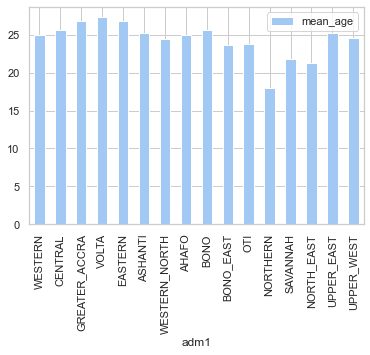

In [127]:
gha_demographic_adm1_2020_population_total = gha_demographic_adm1_raw_data_2020.sum(
    axis=1
)
gha_demographic_adm1_2020_population_median = (
        gha_demographic_adm1_2020_population_total / 2
)
# expand columns, each column = to cumsum the previous columns
gha_demographic_adm1_2020_population_expanding = (
    gha_demographic_adm1_raw_data_2020.expanding(axis=1).sum()
)
# expanded columns - median, the first non negative column is where median
gha_demographic_adm1_2020_raw_subtract_median = (
    gha_demographic_adm1_2020_population_expanding.subtract(
        gha_demographic_adm1_2020_population_median, axis=0
    )
)
# get ratio in groups
# check the answer here
# https://stackoverflow.com/questions/38467749/find-first-non-zero-value-in-each-row-of-pandas-dataframe/38468180
gha_demographic_adm1_2020_median_ratio = (
        gha_demographic_adm1_2020_raw_subtract_median.where(
            gha_demographic_adm1_2020_raw_subtract_median > 0
        )
        / gha_demographic_adm1_raw_data_2020
)
gha_demographic_adm1_2020_median_ratio = (
        gha_demographic_adm1_2020_median_ratio.bfill(1).iloc[:, 0] * 4
)
# get group labels
gha_demographic_adm1_2020_median_group_value = (
        gha_demographic_adm1_raw_data_2020 - gha_demographic_adm1_2020_population_expanding
)
gha_demographic_adm1_median_group_labels = (
        gha_demographic_adm1_2020_raw_subtract_median > 0
).idxmax(axis=1)
# get first two string as the start of age group
gha_demographic_adm1_median_group_labels = (
    gha_demographic_adm1_median_group_labels.apply(lambda _: float(_[1:3]))
)
# add age group with ratio
gha_demographic_adm1_2020_median = (
        gha_demographic_adm1_median_group_labels + gha_demographic_adm1_2020_median_ratio
)

# gha_demographic_adm1_2020_median

# gha_demographic_adm1_2020_mean
gha['total_population'] = gha_demographic_adm1_2020_phc['both_sex'].to_numpy()
# plotting
gha_demographic_adm1_2020_mean.plot.bar()

### Adm2 level population
Data source: GHA/incid from WHO/GMP

In [128]:
incid = pd.read_csv(data_dir + "GHA/Routine_data/District-level/incid.csv")
incid = incid[incid["year"] == 2018]
incid = demographic.reformat.adm1_name(
    df=incid, original_column_name="adm1", set_index=False
)
incid.sample(5)
gha_adm2_population = incid[["adm1", "adm2", "pop"]]
gha_adm2_population = gha_adm2_population.rename(columns={"pop": "population"})
gha_adm2_population.sample(25)

,adm1,adm2,population
756,ASHANTI,OBUASI EAST,94678.0
343,UPPER_EAST,BOLGATANGA MUNICIPAL,127378.0
410,BONO,DORMAA WEST,58626.0
193,CENTRAL,ASSIN NORTH,123641.0
598,ASHANTI,KUMASI METROPOLITAN,2057084.0
717,BONO_EAST,NKORANZA NORTH,80955.0
146,ASHANTI,AKROFUOM,42145.0
975,UPPER_WEST,WA EAST,85233.0
208,AHAFO,ASUTIFI SOUTH,64219.0
748,WESTERN,NZEMA EAST,78671.0


### Exponential Population Distribution - ETA

In the malaria models, exponential distribution was used to simulation the age structure.

Estimation of the **ETA** parameter: death rates for exponential population distribution,

$$ ETA = \frac{1}{MeanAge} $$

Default ETA = 0.0001305

In [129]:
gha["eta"] = 1 / (gha_demographic_adm1_2020_mean * 365)
gha["eta"]

adm1
WESTERN          0.000110
CENTRAL          0.000107
GREATER_ACCRA    0.000102
VOLTA            0.000100
EASTERN          0.000102
ASHANTI          0.000109
WESTERN_NORTH    0.000112
AHAFO            0.000110
BONO             0.000107
BONO_EAST        0.000116
OTI              0.000115
NORTHERN         0.000152
SAVANNAH         0.000126
NORTH_EAST       0.000129
UPPER_EAST       0.000109
UPPER_WEST       0.000112
Name: eta, dtype: float64

### Max age
@param max_age Maximum age in days. Default = 100*365

In [130]:
gha["max_age"] = 100 * 365

In [131]:
# pd.merge(
#    gha,
#
# )
# xml_demography = etree.Element("demography")
# xml_demography.set("maximumAgeYrs", 90)
# xml_demography.set("name", )
# xml_demography.append(etree.Element())

## State transition related parameters

@param rA Rate of leaving asymptomatic infection. Default = 0.00512821

@param rT Rate of leaving treatment. Default = 0.2

@param rD Rate of leaving clinical disease. Default = 0.2

@param rU Rate of recovering from subpatent infection. Default = 0.00906627

@param rP Rate of leaving prophylaxis. Default = 0.06666667

@param dE Latent period of human infection. Default = 12

@param delayGam Lag from parasites to infectious gametocytes. Default = 12.5

@param cD Untreated disease contribution to infectiousness. Default = 0.0676909

@param cT Treated disease contribution to infectiousness. Default =   0.322 * cD

@param cU Subpatent disease contribution to infectiousness. Default = 0.006203

@param gamma1 Parameter for infectiousness of state A. Default = 1.82425

In [132]:
gha["rA"] = 0.00512821
gha["rT"] = 0.2
gha["rD"] = 0.2
gha["rU"] = 0.00906627
gha["rP"] = 0.06666667
# TODO check if this data is available from the data folder
gha["dE"] = 12
gha["delayGam"] = 12.5
gha["cD"] = 0.0676909
gha["cT"] = 0.322 * gha["cD"]
gha["cU"] = 0.006203
gha["gamma1"] = 1.82425

## Immunity parameters
@param d1 Minimum probability due to maximum immunity. Default = 0.160527

@param dID Inverse of decay rate. Default = 3650

@param ID0 Scale parameter. Default = 1.577533

@param kD Shape parameter. Default = 0.476614

@param uD Duration in which immunity is not boosted. Default = 9.44512

@param aD Scale parameter relating age to immunity. Default = 8001.99

@param fD0 Time-scale at which immunity changes with age. Default = 0.007055

@param gammaD Shape parameter relating age to immunity. Default = 4.8183

@param alphaA PCR detection probability parameters state A. Default = 0.757

@param alphaU PCR detection probability parameters state U. Default = 0.186

@param b0 Maximum probability due to no immunity. Default = 0.590076

@param b1 Maximum relative reduction due to immunity. Default = 0.5

@param dB Inverse of decay rate. Default = 3650

@param IB0 Scale parameter. Default = 43.8787

@param kB Shape parameter. Default = 2.15506

@param uB Duration in which immunity is not boosted. Default = 7.19919

@param phi0 Maximum probability due to no immunity. Default = 0.791666

@param phi1 Maximum relative reduction due to immunity. Default = 0.000737

@param dCA Inverse of decay rate. Default = 10950

@param IC0 Scale parameter. Default = 18.02366

@param kC Shape parameter. Default = 2.36949

@param uCA Duration in which immunity is not boosted. Default = 6.06349

@param PM New-born immunity relative to mother’s. Default = 0.774368

@param dCM Inverse of decay rate of maternal immunity. Default = 67.6952

In [133]:
gha["d1"] = 0.160527
gha["dID"] = 3650
gha["ID0"] = 1.577533
gha["kD"] = 0.476614
gha["uD"] = 9.44512
gha["aD"] = 8001.99
gha["fD0"] = 0.007055
gha["gammaD"] = 4.8183
gha["alphaA"] = 0.757
gha["alphaU"] = 0.186
gha["b0"] = 0.590076
# Maximum relative reduction due to immunity
gha["b1"] = 0.5
# Immunity Inverse of decay rate
gha["dB"] = 3650
gha["IB0"] = 43.8787
gha["kB"] = 2.15506
gha["uB"] = 7.19919
gha["phi0"] = 0.791666
gha["phi1"] = 0.000737
gha["dCA"] = 10950
gha["IC0"] = 18.02366
gha["kC"] = 2.36949
gha["uCA"] = 6.06349
gha["PM"] = 0.774368
gha["dCM"] = 67.695

## Vector
### Extrinsic incubation period
@param delayMos Extrinsic incubation period. Default = 10

In [134]:
# TODO check this parameter, extrinsic incubation period
gha["delayMos"] = 10

### Biting parameters
#### Host seeking
@param tau1 Duration of host seeking, assumed to be constant between species. Default = 0.69

#### Duration of resting after feed
@param tau2 Duration of mosquito resting after feed. Default = 2.31

#### Daily mortality rate
@param mu0 Daily mortality of adult mosquitos. Default = 0.132

> TODO use data from Ellie's paper and WHO/GMP data to estimation provincial level *anthrophagy* and *endophily*

#### Anthrophagy
@param Q0 Anthrophagy probability. Default = 0.92

#### Endophily
@param chi Endophily probability. Default = 0.86

#### Bites percentage both indoors and in bed
@param bites_Bed Percentage of bites indoors and in bed. Default = 0.89

#### Bites percentage indoors
@param bites_Indoors Percentage of bites indoors . Default = 0.97

In [135]:
# duration of host seeking, assumed to be constant between species
gha["tau1"] = 0.69
# duration of mosquito resting after feed
gha["tau2"] = 2.31
# daily mortality of adult mosquitos
# TODO
gha["mu0"] = 0.13
# Anthrophagy probability
# TODO
gha["Q0"] = 0.92
# TODO
# Endophily probability
gha["mu0"] = 0.86
# TODO
# Percentage of bites indoors and in bed
gha["bites_Bed"] = 0.89
# Percentage of bites indoors
gha["bites_Indoors"] = 0.97

#### Biting rates
@param rho Age-dependent biting parameter. Default = 0.85

@param a0 Age-dependent biting parameter. Default = 2920

@param sigma2 Variance of the log heterogeneity in biting rates. Default = 1.67

In [136]:
gha["rho"] = 0.85
gha["a0"] = 2920
gha["sigma2"] = 1.67

### Larvae and Pupae
@param muEL Per capita daily mortality rate of early stage larvae (low density). Default = 0.0338

@param muLL Per capita daily mortality rate of late stage larvae (low density). Default = 0.0348

@param muPL Per capita daily mortality rate of pupae. Default = 0.249

@param dEL Development time of early stage larvae. Default = 6.64

@param dLL Development time of late stage larvae. Default = 3.72

@param dPL Development time of pupae. Default = 0.643

@param gammaL Relative effect of density dependence on late instars relative to early instars. Default = 13.25

In [137]:
# Per capita daily mortality rate of early stage larvae(low density)
gha["muEL"] = 0.0338
# Per capita daily mortality rate of late stage larvae(low density)
gha["muLL"] = 0.0348
# Per capita daily mortality rate of pupae
gha["muPL"] = 0.249
# Development time of early stage larvae
gha["dEL"] = 6.64
# Development time of late stage larvae
gha["dLL"] = 3.72
# Development time of pupae
gha["dPL"] = 0.643
# Relative effect of density dependence on late instars relative to early instars
gha["gammaL"] = 13.25

## Seasonal parameters
@param km Seasonal carrying capacity. Default = 11

@param cm Seasonal birth rate. Default = 0.05

@param betaL Number of eggs laid per day per mosquito. Default = 21.2

### Imperial Model Implementation

Fourier's transformation, all the seasonal parameters have been precalculated and provided in their gitHub [repository](https://github.com/mrc-ide/deterministic-malaria-model/blob/master/data-raw/admin_units_seasonal.csv)

By providing the country name and adm1 level district name, the programme will search for the seasonal parameters.

But one problem for Ghana is that they use **216 district**.

The problem was solved by using 216 to 260 district mapping.

In [138]:
# Seasonal carrying capacity
gha["km"] = 11
# Seasonal birth rate
gha["cm"] = 0.05
# N of eggs laid per day per mosquito
gha["betaL"] = 21.2

## Interventions
### Usage
@param num_int Number of intervention parameters.  Default = 4

@param itn_cov The proportion of people that use an ITN. Default = 0

@param irs_cov The proportion of people living in houses that have been sprayed. Default = 0

@param ITN_IRS_on Time of ITN and IRS to be activated. Default = -1, i.e. never.

@param DY Duration of year (days). Default = 365

Data source - GHA_new_district_summaries - WHO/GMP

aggregation over

$$ITN_{adm1} =\frac{\sum{(P_{adm2}*ITN_{adm2})}}{P_{adm1}}$$

$$IRS_{adm1} =\frac{\sum{(P_{adm2}*IRS_{adm2})}}{P_{adm1}}$$

In [139]:
# N of intervention parameters
gha["num_int"] = 2

In [140]:
# Time of ITN and IRS to be activated.
gha["ITN_IRS_on"] = 200
# Duration of years
gha["DY"] = 365

/Users/sepmein/.pyenv/versions/3.9.7/envs/sci2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/sepmein/.pyenv/versions/3.9.7/envs/sci2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='itn_cov'>

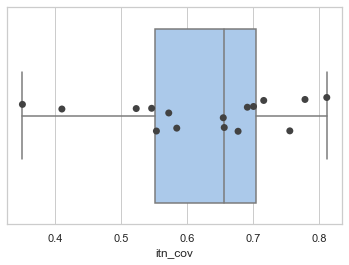

In [141]:
# gha_intervention = pd.read_stata('../Data/GHA/interventions/interventions.dta')
intervention = pd.read_excel(
    io="/Users/sepmein/Dropbox/benchmarking/Data/GHA/MAP_District_Estimates/Maps_by_MAP_260districts/GHA_summaries/GHA_new_district_summaries.xlsx",
    sheet_name="district_summaries",
)
intervention = demographic.reformat.adm1_name(
    df=intervention, original_column_name="REGION", set_index=False
)

intervention = intervention.rename(columns={"DISTRICT": "adm2"})
itn_coverage = intervention[["adm1", "adm2", "ITN_2018"]]
itn_coverage = pd.merge(
    left=gha_adm2_population, right=itn_coverage, left_on="adm2", right_on="adm2"
)

itn_coverage = itn_coverage.drop(columns=["adm1_x"], axis=1)
itn_coverage = itn_coverage.rename(columns={"adm1_y": "adm1"})
itn_coverage["population_itn"] = itn_coverage["population"] * itn_coverage["ITN_2018"]
itn_coverage_groupby_sum = itn_coverage.groupby(by="adm1").sum()
itn_coverage_groupby_sum["itn_coverage"] = (
        itn_coverage_groupby_sum["population_itn"] / itn_coverage_groupby_sum["population"]
)
gha["itn_cov"] = itn_coverage_groupby_sum["itn_coverage"]
gha["pbo_cov"] = gha['itn_cov'] * 2.17 / 3.09
sns.stripplot(gha["itn_cov"], size=7, color=".26")
sns.boxplot(gha["itn_cov"], showfliers=False)

/Users/sepmein/.pyenv/versions/3.9.7/envs/sci2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/sepmein/.pyenv/versions/3.9.7/envs/sci2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


adm1
WESTERN          0.000000
CENTRAL          0.000000
GREATER_ACCRA    0.000000
VOLTA            0.000000
EASTERN          0.000000
ASHANTI          0.000000
WESTERN_NORTH    0.000000
AHAFO            0.000000
BONO             0.000000
BONO_EAST        0.000000
OTI              0.000000
NORTHERN         0.046994
SAVANNAH         0.000033
NORTH_EAST       0.272361
UPPER_EAST       0.027759
UPPER_WEST       0.227559
Name: irs_cov, dtype: float64

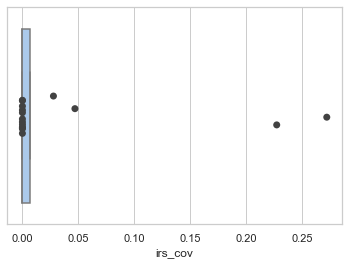

In [142]:
irs_coverage = intervention[["adm1", "adm2", "IRS_2018"]]
irs_coverage = pd.merge(
    left=gha_adm2_population, right=irs_coverage, left_on="adm2", right_on="adm2"
)

irs_coverage = irs_coverage.drop(columns=["adm1_x"], axis=1)
irs_coverage = irs_coverage.rename(columns={"adm1_y": "adm1"})
irs_coverage["population_irs"] = irs_coverage["population"] * irs_coverage["IRS_2018"]
irs_coverage_groupby_sum = irs_coverage.groupby(by="adm1").sum()
irs_coverage_groupby_sum["irs_coverage"] = (
        irs_coverage_groupby_sum["population_irs"] / irs_coverage_groupby_sum["population"]
)
gha["irs_cov"] = irs_coverage_groupby_sum["irs_coverage"]
sns.stripplot(gha["irs_cov"], size=7, color=".26")
sns.boxplot(gha["irs_cov"], showfliers=False)
gha["irs_cov"]

In [143]:
# ITN distributed
gha_intervention_data_excel = pd.read_excel(
    "../../Data/GHA/Interventions/GHA_Intervention_data.xlsx",
    sheet_name="Data template "
)
gha_intervention_data_excel_2018 = gha_intervention_data_excel[gha_intervention_data_excel['year'] == 2018]
gha_intervention_data_excel_2018 = gha_intervention_data_excel_2018.dropna(subset=['adm1'])
gha_intervention_data_excel_2018 = gha_intervention_data_excel_2018.replace('Northern East', 'north east')
llins_distributed = gha_intervention_data_excel_2018.groupby('adm1').sum()['llins_num']
llins_distributed = demographic.reformat.adm1_name(df=llins_distributed,
                                                   original_column_name='adm1',
                                                   )

gha['llins_distributed'] = llins_distributed
gha['llins_distributed']

adm1
WESTERN          1272959.0
CENTRAL          1529422.0
GREATER_ACCRA    2276290.0
VOLTA            1016829.0
EASTERN          1660200.0
ASHANTI          2718415.0
WESTERN_NORTH     691062.0
AHAFO             345427.0
BONO              638279.0
BONO_EAST         609677.0
OTI               430064.0
NORTHERN         1055158.0
SAVANNAH          344933.0
NORTH_EAST         47105.0
UPPER_EAST        653181.0
UPPER_WEST             0.0
Name: llins_distributed, dtype: float64

### Efficacy
@param d_ITN0 Probability of dying with an encounter with ITN (max). Default = 0.41

@param r_ITN0 Probability of repeating behaviour with ITN (max). Default = 0.56

@param r_ITN1 Probability of repeating behaviour with ITN (min). Default = 0.24

@param r_IRS0 Probability of repeating behaviour with IRS (min). Default = 0.6

@param d_IRS0 Probability of dying with an encounter with IRS (max). Default = 1

In [144]:
converter = efficacy.Converter()
for x in np.nditer(np.linspace(0, 1, 20)):
    y = converter.bioassay_to_rds(x)
    print("regular, repeating: ", "{:10.2f}".format(y[0][0]))
    print("regular, repeating, with decay:", "{:10.2f}".format(y[0][1]))
    print("regular, dying: ", "{:10.2f}".format(y[0][2]))
    print("regular, feeding: ", "{:10.2f}".format(y[0][3]))
    print("PBO, repeating: ", "{:10.2f}".format(y[1][0]))
    print("PBO, repeating, with decay:", "{:10.2f}".format(y[1][1]))
    print("PBO, dying: ", "{:10.2f}".format(y[1][2]))
    print("PBO, feeding: ", "{:10.2f}".format(y[1][3]))

regular, repeating:        0.68
regular, repeating, with decay:       0.24
regular, dying:        0.23
regular, feeding:        0.09
PBO, repeating:        0.57
PBO, repeating, with decay:       0.24
PBO, dying:        0.38
PBO, feeding:        0.05
regular, repeating:        0.65
regular, repeating, with decay:       0.24
regular, dying:        0.27
regular, feeding:        0.08
PBO, repeating:        0.51
PBO, repeating, with decay:       0.24
PBO, dying:        0.46
PBO, feeding:        0.03
regular, repeating:        0.62
regular, repeating, with decay:       0.24
regular, dying:        0.31
regular, feeding:        0.07
PBO, repeating:        0.54
PBO, repeating, with decay:       0.24
PBO, dying:        0.45
PBO, feeding:        0.01
regular, repeating:        0.59
regular, repeating, with decay:       0.24
regular, dying:        0.35
regular, feeding:        0.06
PBO, repeating:        0.64
PBO, repeating, with decay:       0.24
PBO, dying:        0.35
PBO, feeding:        0.01


In [145]:
# Probability of dying with an encounter with ITN(max)
gha["d_ITN0"] = 0.41

# load mortality settings vs LLINs & PBO nets
mortality_llins_vs_pbo = pd.read_csv(
    data_dir + "LLINs vs PBO/mortality rate llins vs pbo.csv"
)
# load resistance settings in each adm1
gha_adm1_vector_resistance = pd.read_excel(
    data_dir
    + "GHA/WHO_IR_data/MTM_DISCRIMINATING_CONCENTRATION_BIOASSAY_20211130.xlsx",
    sheet_name="Data",
)
# rename Brong Ahafo to Brong-Ahafo
gha_adm1_vector_resistance = gha_adm1_vector_resistance.replace(
    "Brong Ahafo", "Brong-Ahafo"
)

# subgroup
gha_adm1_vector_resistance = gha_adm1_vector_resistance.groupby("ADMIN1").mean()

gha_adm1_vector_resistance = gha_adm1_vector_resistance["MORTALITY_ADJUSTED"]
gha = gha.merge(
    right=gha_adm1_vector_resistance,
    how="left",
    left_on="old_district_name",
    right_index=True,
)

In [146]:
ellie_2022_llins_pbo = pd.read_excel(
    "/Users/sepmein/Dropbox/benchmarking/Data/LLINs vs PBO/ellie-2022-llins-vs-pbo.xlsx", sheet_name="Sheet1")


def test_convert(mortality):
    resistance = 1 - mortality
    if resistance < .1:
        resistance_level = .0
    elif resistance < .30:
        resistance_level = .2
    elif resistance < .50:
        resistance_level = .4
    elif resistance < .70:
        resistance_level = .6
    elif resistance < .90:
        resistance_level = .8
    else:
        resistance_level = 1

    result = ellie_2022_llins_pbo[ellie_2022_llins_pbo['resistance'] == resistance_level]

    r10 = result['r10'].values[0]
    d10 = result['d10'].values[0]
    r20 = result['r20'].values[0]
    d20 = result['d20'].values[0]
    h1 = result['h1'].values[0]
    h2 = result['h2'].values[0]

    return r10, d10, r20, d20, h1, h2


test_convert(.3)

(0.626, 0.27, 0.525, 0.419, 1.616, 1.311)

In [147]:
gha["r_ITN_0"] = gha["MORTALITY_ADJUSTED"].map(
    lambda _: test_convert(_ / 100)[0]
)
gha["r_PBO_0"] = gha["MORTALITY_ADJUSTED"].map(
    lambda _: test_convert(_ / 100)[2]
)
# gha["r_ITN_1"] = gha["MORTALITY_ADJUSTED"].map(
#     lambda _: test_convert(_ / 100)[0][1]
# )
# gha["r_PBO_1"] = gha["MORTALITY_ADJUSTED"].map(
#     lambda _: converter.bioassay_to_rds(_ / 100)[1][1]
# )
gha["d_ITN_0"] = gha["MORTALITY_ADJUSTED"].map(
    lambda _: test_convert(_ / 100)[1]
)
gha["d_PBO_0"] = gha["MORTALITY_ADJUSTED"].map(
    lambda _: test_convert(_ / 100)[3]
)
gha["h_ITN"] = gha["MORTALITY_ADJUSTED"].map(
    lambda _: test_convert(_ / 100)[4]
)
gha["h_PBO"] = gha["MORTALITY_ADJUSTED"].map(
    lambda _: test_convert(_ / 100)[5]
)
# categorize resistance into h/m/l groups
# gha_adm1_vector_resistance_groups = pd.cut(
#     x=gha_adm1_vector_resistance,
#     bins=[0.0, 30, 60, 100],
#     labels=['high', 'moderate', 'low']
# )
# as the data from WHO/GMP/Malaria Threats Map still use 216 system
# I need to transform to the 260 system first
# gha['']

# Probability of repeating behaviour with ITN(max)
# gha["r_ITN0"] = 0.56
# Probability of repeating behaviour with ITN(min)
# gha["r_ITN1"] = 0.24
# Probability of repeating behaviour with IRS(min)
gha["r_IRS0"] = 0.6
# Probability of dying with an encounter with IRS(max)
gha["d_IRS0"] = 1

In [148]:
# gha = gha.merge(right=gha_adm1_vector_resistance_groups,
#                 how="left",
#                 left_on="old_district_name",
#                 right_index=True
#                 )
# gha.loc[gha['MORTALITY_ADJUSTED'] == 'low', 'd_ITN0_LLINs'] = .527
# gha.loc[gha['MORTALITY_ADJUSTED'] == 'low', 'd_ITN0_PBO'] = .659
# gha.loc[gha['MORTALITY_ADJUSTED'] == 'moderate', 'd_ITN0_LLINs'] = .18
# gha.loc[gha['MORTALITY_ADJUSTED'] == 'moderate', 'd_ITN0_PBO'] = .303
# gha.loc[gha['MORTALITY_ADJUSTED'] == 'high', 'd_ITN0_LLINs'] = .238
# gha.loc[gha['MORTALITY_ADJUSTED'] == 'high', 'd_ITN0_PBO'] = .438

### Decay
@param irs_half_life IRS half life. Default =   0.5 * DY

@param itn_half_life ITN half life. Default =   2.64 * DY

In [149]:
# IRS half life
gha["irs_half_life"] = 0.5 * 365
# ITN half life
gha["itn_half_life"] = 2.64 * 365

### Implementation
@param IRS_interval How long before IRS is repeated, i.e. when IRS decay = 1. Default =   1 * DY

@param ITN_interval How long before ITN is repeated, i.e. when IRS decay = 1.  Default =   3 * DY

In [150]:
# How long before IRS is repeated
gha["IRS_interval"] = 1 * 365
# how long before ITN is repeated
gha["ITN_interval"] = 3 * 365

In [151]:
GHA_Intervention_data = pd.read_excel(
    data_dir + "GHA/Interventions/GHA_Intervention_data.xlsx", "Data template "
)
GHA_Intervention_data

,adm1,adm2,year,month,smc_yn,llins_yn,irs_yn,pbo_yn,smc1_num,smc2_num,smc3_num,smc4_num,llins_num,irs_cov,irs_popprot,irs_struct_target,irs_struct_spr
0,NaN,NaN,2008,NaN,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Northern,Gushegu,2008,NaN,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,89994,NaN,38874
2,Northern,Karaga,2008,NaN,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,75290,NaN,29114
3,Northern,Savelugu,2008,NaN,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,116579,NaN,44610
4,Northern,Tolon,2008,NaN,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,160043,NaN,68182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,Western North,Bodi,2018,NaN,0,1,0,0,NaN,NaN,NaN,NaN,54740.0,NaN,NaN,NaN,NaN
747,Western North,Juaboso,2018,NaN,0,1,0,0,NaN,NaN,NaN,NaN,96144.0,NaN,NaN,NaN,NaN
748,Western North,Sefwi Akontombra,2018,NaN,0,1,0,0,NaN,NaN,NaN,NaN,61735.0,NaN,NaN,NaN,NaN
749,Western North,Sefwi-Wiawso,2018,NaN,0,1,0,0,NaN,NaN,NaN,NaN,96608.0,NaN,NaN,NaN,NaN


In [152]:
pd.merge(
    gha_admin1,
    GHA_Intervention_data,
    left_on="adm1",
    right_on="adm1",
)

,adm1,code,adm2,year,month,smc_yn,llins_yn,irs_yn,pbo_yn,smc1_num,smc2_num,smc3_num,smc4_num,llins_num,irs_cov,irs_popprot,irs_struct_target,irs_struct_spr


## EIR estimation

Data source: literature search

- Searched with the keyword 'eir', 'entomology inoculation rate', 'Ghana'
- Created a database on EIR for about 800 records

In [153]:
eir = pd.read_csv(data_dir + "eir.csv")
ghana_eir = eir[eir["Country"] == "Ghana"]

<AxesSubplot:xlabel='setting', ylabel='eir'>

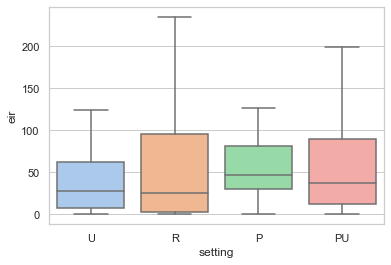

In [154]:
sns.boxplot(data=eir, y="eir", x="setting", showfliers=False)

<AxesSubplot:xlabel='Year_Categorical', ylabel='eir'>

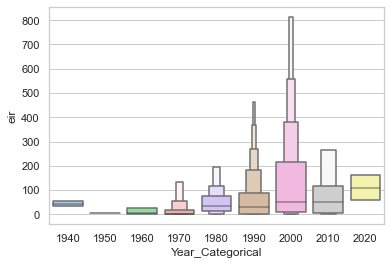

In [155]:
eir["Year_Categorical"] = eir["Year"] // 10 * 10
sns.boxenplot(data=eir, y="eir", x="Year_Categorical", showfliers=False)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'ashanti'),
  Text(1, 0, 'Bono'),
  Text(2, 0, 'Bono east'),
  Text(3, 0, 'Greater Accra'),
  Text(4, 0, 'Upper east')])

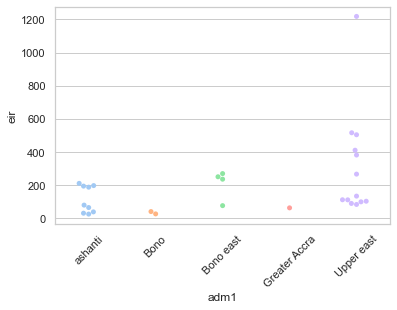

In [156]:
# plot ghana eir data
# TODO: To include 95%CI low and high data.
g = sns.swarmplot(data=ghana_eir, y="eir", x="adm1")
plt.xticks(rotation=45)

### Ghana EIR calculation and missing provinces data estimation

1. search through papers to find eir dataset
2. generate existing dataset
3. check availability for adm1
4. calculate eir for available adm1 region
5. estimate eir for unavailable adm1 region

<AxesSubplot:xlabel='adm1'>

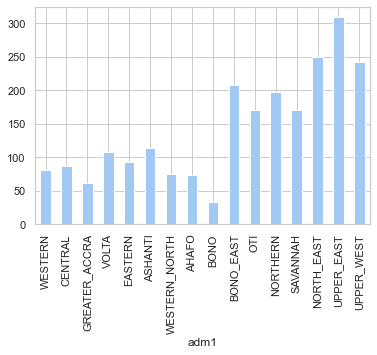

In [157]:
gha_eir = ghana_eir.groupby(by="adm1").mean()
gha_eir = gha_eir["eir"]
gha_eir = demographic.reformat.adm1_name(gha_eir)
# gha_eir
gha["eir"] = gha_eir
gha = util.missing_data_interpolate(
    df=gha, neighbour=gha_adjacent_provinces, column="eir", round_n=100
)
gha["eir"].plot.bar()

## Treatment seeking

Data source - WHO/GMP
Latest data - 2016

- **any_treat** - percentage of treatment from public sector **and** private sector
- **pub_treat** - data from **only** public sector

,adm1,any_treat,pub_treat
0,Western,0.582970,0.356210
1,Central,0.702795,0.294569
2,Greater Accra,0.757498,0.258062
3,Volta,0.789922,0.405711
4,Eastern,0.827497,0.417564
5,Ashanti,0.606210,0.193321
6,Brong Ahafo,0.757674,0.487024
7,Northern,0.849404,0.521830
8,Upper East,0.852665,0.581014
9,Upper West,0.639017,0.472995


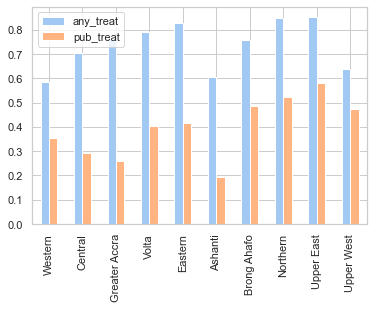

In [158]:
# 216 region
treatment_seeking_216 = pd.read_csv(
    data_dir
    + "GHA/MAP_District_Estimates/Maps_byMAP_216districts/GHA_regional_DHS_treatment_seeking/GHA_TreatmentSeeking.csv"
)
treatment_seeking_216 = treatment_seeking_216.rename(columns={"REGNAME": "adm1"})
treatment_seeking_216 = treatment_seeking_216[["adm1", "any_treat", "pub_treat"]]

ax = treatment_seeking_216.plot(kind="bar")
##ax.set_xticks(treatment_seeking_216[['adm1']])
ax.set_xticklabels(treatment_seeking_216["adm1"])

##treatment_seeking_216[['adm1']]
treatment_seeking_216

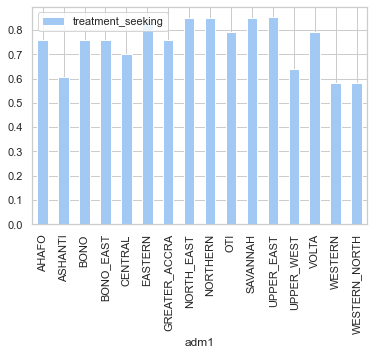

In [159]:
# 260 region

treatment_seeking_260 = pd.read_excel(
    data_dir + "GHA/MIS-DHS_data/GHA_treatment_seeking_tprs_adm1_16regions.xlsx",
    "Sheet",
)
treatment_seeking_260 = treatment_seeking_260[["adm1", "pub_treat"]]
treatment_seeking_260 = treatment_seeking_260.rename(
    columns={"pub_treat": "treatment_seeking"}
)

treatment_seeking_260 = demographic.reformat.adm1_name(
    df=treatment_seeking_260, original_column_name="adm1"
)
# treatment_seeking_260

ax = treatment_seeking_260.plot(kind="bar")
##ax.set_xticks(treatment_seeking_216[['adm1']])

In [160]:
gha = pd.merge(
    left=gha, right=treatment_seeking_260, how="left", left_index=True, right_index=True
)
gha["treatment_seeking"]

adm1
WESTERN          0.582970
CENTRAL          0.702795
GREATER_ACCRA    0.757498
VOLTA            0.789922
EASTERN          0.827497
ASHANTI          0.606210
WESTERN_NORTH    0.582970
AHAFO            0.757674
BONO             0.757674
BONO_EAST        0.757674
OTI              0.789922
NORTHERN         0.849404
SAVANNAH         0.849404
NORTH_EAST       0.849404
UPPER_EAST       0.852665
UPPER_WEST       0.639017
Name: treatment_seeking, dtype: float64

# Map ploting with Shapefile in PYTHON

In [161]:
# shapefile
gha_shape = shapefile.Reader(
    data_dir
    + "GHA/WHO_Health_District_Shapefiles/Ghana _Shape_260 Districts_Boundary. 26.06.2019/260_Districts_of_Ghana"
)
shapes = gha_shape.shapes()

In [162]:
# for shape in shapes:
#     for point in shape.points:
#         x,y = point
#         plt.plot(x,y)
# plt.show()

In [163]:
gha_shape.records()


def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords'
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [_[0] for _ in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df


gha_shape_df = read_shapefile(gha_shape)
# gha_shape_df.shape
gha_shape_df.sample(5)

,REGION,DISTRICT,DIST_CODE,AREA,PERIMETER,AREA_KM,CreationDa,Creator,EditDate,coords
46,AHAFO,TANO NORTH MUNICIPAL,0707,9.013978e+09,618418.26210,837.4256,2016-02-18,jAdjei@USAID_Ghana_HPNO,2016-02-18,"[(-229867.63626196183, 817029.0572050265), (-2..."
60,CENTRAL,TWIFO ATTI-MORKWA,0215,1.028382e+10,619626.52276,955.3981,2016-02-18,jAdjei@USAID_Ghana_HPNO,2016-02-18,"[(-178716.45346751588, 652376.1646446584), (-1..."
175,ASHANTI,AHAFO ANO NORTH,0617,6.390109e+09,565591.92070,593.6603,2016-02-18,jAdjei@USAID_Ghana_HPNO,2016-02-18,"[(-237697.0291236697, 784350.6609255057), (-23..."
115,EASTERN,KWAHU AFRAM PLAINS NORTH,0521,2.520139e+10,843074.17120,2341.2847,2016-02-18,jAdjei@USAID_Ghana_HPNO,2016-02-18,"[(-15845.803485393972, 803098.9980061789), (-1..."
82,VOLTA,AGOTIME ZIOPE,0407,3.397653e+09,396621.50540,315.6521,2016-02-18,jAdjei@USAID_Ghana_HPNO,2016-02-18,"[(83403.22743918838, 719329.2263381509), (8332..."


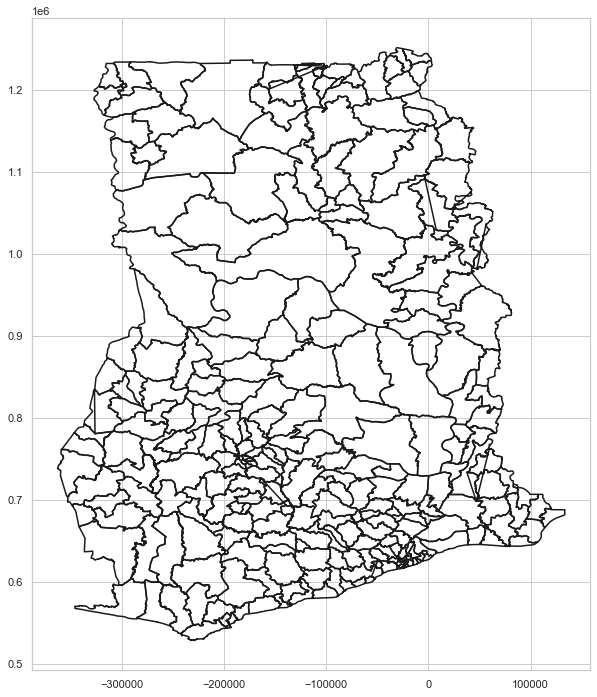

In [164]:
def plot_shape(_id, s=None, sf=None):
    """PLOTS A SINGLE SHAPE"""
    plt.figure()
    _ax = plt.axes()
    _ax.set_aspect("equal")
    shape_ex = sf.shape(_id)
    x_lon = np.zeros((len(shape_ex.points), 1))
    y_lat = np.zeros((len(shape_ex.points), 1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
    plt.plot(x_lon, y_lat)
    x0 = np.mean(x_lon)
    y0 = np.mean(y_lat)
    plt.text(x0, y0, s, fontsize=10)
    # use bbox (bounding box) to set plot limits
    plt.xlim(shape_ex.bbox[0], shape_ex.bbox[2])
    return x0, y0


def plot_map(sf, x_lim=None, y_lim=None, figsize=(11, 9)):
    """
    Plot map with lim coordinates
    """
    plt.figure(figsize=figsize)
    # id = 0
    for shape in sf.shapeRecords():
        _x = [i[0] for i in shape.shape.points[:]]
        _y = [i[1] for i in shape.shape.points[:]]
        plt.plot(_x, _y, "k")

        # if (x_lim == None) & (y_lim == None):
        #    x0 = np.mean(x)
        #    y0 = np.mean(y)
        #    plt.text(x0, y0, id, fontsize=10)
        # id = id+1

    if (x_lim is not None) & (y_lim is not None):
        plt.xlim(x_lim)
        plt.ylim(y_lim)


plot_map(gha_shape, figsize=(10, 12))

### Export to Imperial models

In [165]:
gha.to_csv(data_dir + "GHA/gha.csv")

### Openmalaria
1. load default vec model from openmalaria github example configuration
2. modify the according configuration based on each district
3. export to xml configures for each 260 district
4. run openmalaria model

In [166]:
# load vec model xml configuration
om_xml_root = load_xml_config(openmalaria_xml_config_path)
# create tuple for holding all the district xml configuration data
# map through gha index
ghana_xml = gha.index.map(
    lambda district: {
        load_xml_config(openmalaria_xml_config_path)
    }
)

In [167]:
# skip demographic configuration for now, as it was recommended in openmalaria wiki doc

#### Monitoring

In [175]:
from lxml import etree
from typing import Dict


class OmXml:
    def __init__(self, df, xml_framework):
        self.list = df.index.map(
            lambda district: load_xml_config(xml_framework)
        )
        self.df = df

    def remove_attr(self, tag: str, attrib: str):
        def _rm(xml):
            for node in xml.findall(tag):
                del node.findall(tag).attrib[attrib]

        self.list.map(_rm)

    def set_attr(self,
                 tag: str,
                 attrib: str,
                 new_value=None,
                 df_column: str = None,
                 fn: Callable = lambda i: i,
                 use_df_index: bool = False,
                 ):

        def _set_attr(xml, value):
            # some value is float, translate it into string
            if isinstance(value, float) or isinstance(value, int):
                value = str(value)
            for node in xml.findall(tag):
                node.attrib[attrib] = value

        # use self index as value
        if use_df_index:
            map(
                lambda xml, index: _set_attr(xml, fn(index)),
                self.list,
                self.df.index
            )
        elif df_column:
            map(
                lambda xml, column: _set_attr(xml, fn(column)),
                self.list,
                self.df[df_column]
            )
        else:
            self.list.map(
                lambda xml: _set_attr(xml, new_value))

    def add_tag(self,
                to,
                tag,
                attrib: Dict = None,
                content: str = None):
        def _add_tag(xml):
            for node in xml.iter(to):
                to_insert = etree.Element(tag)
                if content:
                    to_insert.text = content
                if attrib:
                    for key, value in attrib.items():
                        to_insert.attrib[key] = value
                node.append(to_insert)

        map(
            lambda xml: _add_tag(xml),
            self.list
        )

    def add_child_from_xml_string(self, parent,
                                  df_xml_string_column_name
                                  ):
        # print(parent)
        # for _ in self.list[0].iter(parent):
        #     print('test')
        def _add_child_from_xml_string(_xml,
                                       child_xml_string: str):
            for _ in _xml.iter(parent):
                to_insert = etree.fromstring(child_xml_string)
                _.insert(0, to_insert)

        for xml, district_xml_string in zip(self.list, self.df[df_xml_string_column_name]):
            _add_child_from_xml_string(
                xml, child_xml_string=district_xml_string
            )
        # self.list = _list(map(
        #     lambda xml, string: _add_child_from_xml_string(xml, string),
        #     self.list,
        #     self.df[df_xml_string_column_name]
        # ))

    def remove_tag(self, tag):
        def _remove_tag(xml, _tag):
            for node in xml.findall(_tag):
                parent = node.getparent()
                parent.remove(node)

        map(
            lambda xml: _remove_tag(xml, tag)
            , self.list)

    def remove_child(self, tag):
        """
         remove child of a tag
         :param tag: xpath string for a path
        """

        def _remove_child(xml):
            for found in xml.findall(tag):
                for child in found:
                    found.remove(child)

            map(
                lambda xml: _remove_child(xml),
                self.list
            )

    def print_tag(self, tag):
        def _print(xml):
            for node in xml:
                print(etree.dump(node))

        list(
            map(
                lambda xml: _print(xml.findall(tag)),
                self.list
            )
        )

    def head(self, tag: str, n: int = 1
             ):
        """
        print out first few tags in for the selected tag
        :param tag: xpath string to print
        :param n: first n configuration to be printed out
        """
        for i in range(n):
            print(etree.dump(
                self.list[i].findall(tag)
            ))

    def set_monitoring(self):
        # remove date attribute
        self.set_attr(tag='monitoring',
                      attrib='name',
                      use_df_index=True
                      )
        # self.remove_tag('monitoring/continuous')
        # self.remove_tag('monitoring/SurveyOptions')
        # self.insert(parent='monitoring',
        #             tag='SurveyOptions',
        #             )
        # self.insert(parent='monitoring/SurveyOptions',
        #             tag='options',
        #             attrib={
        #                 'name': 'nInfect'
        #             }
        #             )

    def set_intervention(self):
        # self set
        pass

In [176]:
gha_xml_om = OmXml(df=gha,
                   xml_framework=openmalaria_xml_config_path)
gha_xml_om.set_monitoring()
# gha_xml_om.head('monitoring')
gha_xml_om.set_intervention()
# gha_xml_om.head('interventions')

gha_xml_om.set_attr(tag="interventions/human/deployment/timed/deploy",
              attrib='coverage',
              df_column='itn_cov'
              )
# remove deployment/timed/deploy configuration
gha_xml_om.remove_child(tag='intervention/human/deployment/timed')
gha_xml_om.set_attr(tag="entomology",
                    attrib="scaledAnnualEIR",
                    df_column="eir"
                    )
# set annual EIR

In [177]:
# seasonality
subnational_monthly_data = pd.read_csv(data_dir + "GHA/Routine_data/District-level/subnational_monthly_data.csv")
# get only 2018 data (latest)
# subnational_monthly_data = subnational_monthly_data[subnational_monthly_data['year'] == 2018]
# replace month name with number
subnational_monthly_data = subnational_monthly_data.replace('January', 1)
subnational_monthly_data = subnational_monthly_data.replace('February', 2)
subnational_monthly_data = subnational_monthly_data.replace('March', 3)
subnational_monthly_data = subnational_monthly_data.replace('April', 4)
subnational_monthly_data = subnational_monthly_data.replace('April', 4)
subnational_monthly_data = subnational_monthly_data.replace('April', 4)
subnational_monthly_data = subnational_monthly_data.replace('May', 5)
subnational_monthly_data = subnational_monthly_data.replace('June', 6)
subnational_monthly_data = subnational_monthly_data.replace('July', 7)
subnational_monthly_data = subnational_monthly_data.replace('August', 8)
subnational_monthly_data = subnational_monthly_data.replace('September', 9)
subnational_monthly_data = subnational_monthly_data.replace('October', 10)
subnational_monthly_data = subnational_monthly_data.replace('November', 11)
subnational_monthly_data = subnational_monthly_data.replace('December', 12)
subnational_monthly_data = subnational_monthly_data.groupby(['adm1', 'mon']).sum()
# groupby month and adm1
subnational_monthly_data = subnational_monthly_data['allout']
# to csv:
subnational_monthly_data.to_csv(data_dir + 'GHA/subnational_cases_monthly.csv')

In [178]:
gha_fourier = pd.read_csv(data_dir + "GHA/gha_adm1_fourier_transformation_xml.csv")
gha_fourier = demographic.reformat.adm1_name(df=gha_fourier)
gha['fourier'] = gha_fourier['fourier_xml']

In [179]:
etree.fromstring(gha['fourier'][1])

<Element fourierSeries at 0x139d20b80>

In [180]:
gha_xml_om.remove_tag("entomology/vector/anopheles/seasonality/monthlyValues")
gha_xml_om.add_child_from_xml_string(
    parent='seasonality',
    df_xml_string_column_name='fourier'
)



<seasonality xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:om="http://openmalaria.org/schema/scenario_43" annualEIR="5" input="EIR">
					</seasonality>
				
None
<seasonality xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:om="http://openmalaria.org/schema/scenario_43" annualEIR="0.055843" input="EIR">
					</seasonality>
				
None
<seasonality xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:om="http://openmalaria.org/schema/scenario_43" annualEIR="5" input="EIR">
					</seasonality>
				
None
<seasonality xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:om="http://openmalaria.org/schema/scenario_43" annualEIR="0.003785" input="EIR">
					</seasonality>
				
None
<seasonality xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:om="http://openmalaria.org/schema/scenario_43" annualEIR="5" input="EIR">
					</seasonality>
				
None
<seasonality xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:om="http://openmalaria.org/s